# Bocetos Meteorológicos de QuickDraw - Transfer Learning vs Entrenamiento desde Cero
Este cuaderno documenta el pipeline completo del proyecto final de Procesamiento de Imágenes: carga del dataset (500 bocetos), preprocesamiento, entrenamiento de dos arquitecturas (Red A con Transfer Learning y Red B desde cero), evaluación con métricas/matrices de confusión y generación automática del informe escrito.

## 1. Cargar y Explorar el Dataset
Usaremos `pandas` para inspeccionar las 500 imágenes (28×28) provenientes de QuickDraw, verificando integridad con `head()`, `info()`, `describe()` y graficando la distribución de clases antes de entrenar.

Forma del dataset: (500, 28, 28, 1), Etiquetas: (500,)


,0,1,2,3,4,5,6,7,8,9,...,775,776,777,778,779,780,781,782,783,etiqueta
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1



Información del DataFrame:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Columns: 785 entries, 0 to etiqueta
dtypes: float64(784), int64(1)
memory usage: 3.0 MB

Descripción (primeras 5 características):


,0,1,2,3,4
count,500.0,500.0,500.0,500.0,500.0
mean,0.0,0.0,0.0,0.0,0.0
std,0.0,0.0,0.0,0.0,0.0
min,0.0,0.0,0.0,0.0,0.0
25%,0.0,0.0,0.0,0.0,0.0


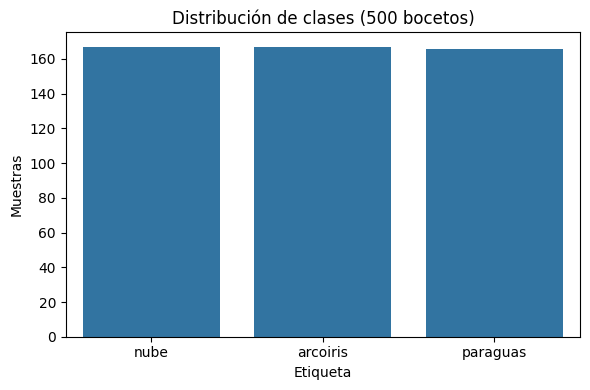

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path


def cargar_dataset_local(ruta_x='X.npy', ruta_y='y.npy'):
    ruta_x = Path(ruta_x)
    ruta_y = Path(ruta_y)
    if not ruta_x.exists() or not ruta_y.exists():
        raise FileNotFoundError('No se encontraron X.npy / y.npy.')

    imagenes = np.load(ruta_x)
    imagenes = imagenes.astype('float32')
    if imagenes.max() > 1.0:
        imagenes = imagenes / 255.0
    if imagenes.ndim == 3:
        imagenes = imagenes[..., None]

    etiquetas = np.load(ruta_y)
    return imagenes, etiquetas


MAPA_ETIQUETAS = {0: 'nube', 1: 'arcoiris', 2: 'paraguas'}

imagenes_crudas, etiquetas_crudas = cargar_dataset_local('X.npy', 'y.npy')
print(f"Forma del dataset: {imagenes_crudas.shape}, Etiquetas: {etiquetas_crudas.shape}")

# Aplanar imágenes para inspección tabular
imagenes_planas = imagenes_crudas.reshape(imagenes_crudas.shape[0], -1)
df_bocetos = pd.DataFrame(imagenes_planas)
df_bocetos['etiqueta'] = etiquetas_crudas

display(df_bocetos.head())
print('\nInformación del DataFrame:')
df_bocetos.info()
print('\nDescripción (primeras 5 características):')
display(df_bocetos.describe().iloc[:5, :5])

plt.figure(figsize=(6,4))
sns.countplot(x=df_bocetos['etiqueta'].map(MAPA_ETIQUETAS))
plt.title('Distribución de clases (500 bocetos)')
plt.ylabel('Muestras')
plt.xlabel('Etiqueta')
plt.tight_layout()
plt.show()

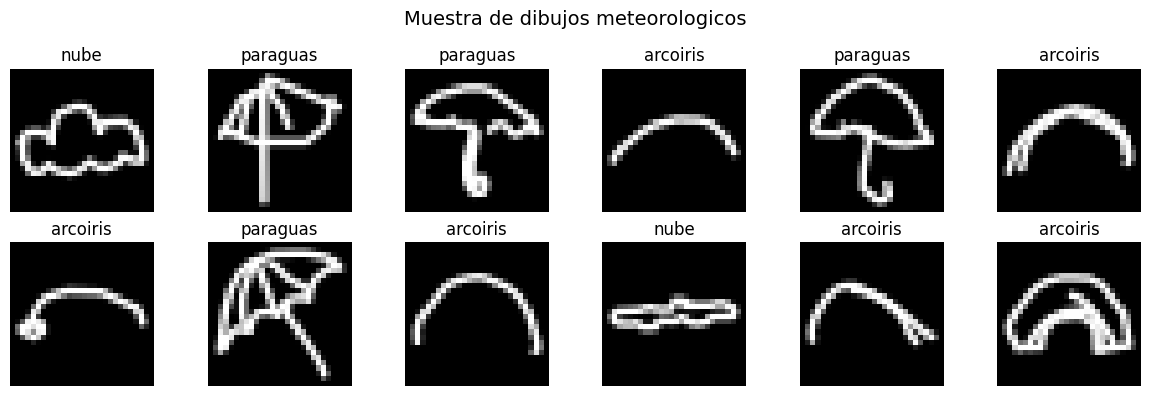

In [12]:
# Vista rápida de 12 bocetos aleatorios
muestras = 12
indices = np.random.choice(imagenes_crudas.shape[0], muestras, replace=False)
columnas = 6
filas = muestras // columnas
fig, ejes = plt.subplots(filas, columnas, figsize=(12,4))
for eje, idx in zip(ejes.flatten(), indices):
    imagen = imagenes_crudas[idx, :, :, 0]
    eje.imshow(imagen, cmap='gray')
    eje.set_title(MAPA_ETIQUETAS[int(etiquetas_crudas[idx])])
    eje.axis('off')
plt.suptitle('Muestra de dibujos meteorologicos', fontsize=14)
plt.tight_layout()
plt.show()

## 2. Preprocesar Características y Etiquetas
Normalizamos las imágenes (0–1), añadimos el canal requerido y dividimos los datos en subconjuntos de entrenamiento/validación/prueba con ayuda de `scikit-learn` y `FunctionTransformer` para dejar la transformación registrada en un pipeline reproducible.

In [13]:
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import FunctionTransformer

# No hay valores faltantes en imágenes binarias, pero registramos la normalización en un pipeline

def escalar_y_agregar_canal(imagenes):
    imagenes = imagenes.astype('float32')
    if imagenes.max() > 1.0:
        imagenes = imagenes / 255.0
    if imagenes.ndim == 3:
        imagenes = imagenes[..., None]
    return imagenes

pipeline_imagenes = Pipeline([
    ('escala', FunctionTransformer(escalar_y_agregar_canal, validate=False))
])

# División 60/20/20 para entrenamiento/validación/prueba
imgs_entrenamiento, imgs_temporales, etq_entrenamiento, etq_temporales = train_test_split(
    imagenes_crudas, etiquetas_crudas, test_size=0.4, random_state=42, stratify=etiquetas_crudas
)
imgs_validacion, imgs_prueba, etq_validacion, etq_prueba = train_test_split(
    imgs_temporales, etq_temporales, test_size=0.5, random_state=42, stratify=etq_temporales
)

imgs_entrenamiento = pipeline_imagenes.fit_transform(imgs_entrenamiento)
imgs_validacion = pipeline_imagenes.transform(imgs_validacion)
imgs_prueba = pipeline_imagenes.transform(imgs_prueba)

print('Entrenamiento:', imgs_entrenamiento.shape, 'Validación:', imgs_validacion.shape, 'Prueba:', imgs_prueba.shape)
print('Rango después del pipeline:', float(imgs_entrenamiento.min()), 'a', float(imgs_entrenamiento.max()))

Entrenamiento: (300, 28, 28, 1) Validación: (100, 28, 28, 1) Prueba: (100, 28, 28, 1)
Rango después del pipeline: 0.0 a 1.0


## 3. Entrenar Red A (Transfer Learning)
Red A replica el demo visto en clase con dos fases: primero recalibramos las capas densas manteniendo las convolucionales congeladas y luego liberamos todo el backbone con una tasa de aprendizaje mayor más `ReduceLROnPlateau`/`EarlyStopping` para forzar que la red se adapte al dominio de bocetos sin colapsar en una sola clase.

In [14]:
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Conv2D, MaxPool2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.datasets import mnist


def construir_cnn(num_clases, tasa_dropout=0.0):
    return Sequential([
        Conv2D(32, (3,3), activation='relu', input_shape=(28,28,1)),
        MaxPool2D(),
        Conv2D(64, (3,3), activation='relu', padding='same'),
        MaxPool2D(),
        Conv2D(128, (3,3), activation='relu', padding='same'),
        MaxPool2D(),
        Flatten(),
        Dense(128, activation='relu'),
        Dropout(tasa_dropout),
        Dense(num_clases, activation='softmax')
    ])


def entrenar_red_a(imgs_entrenamiento, etq_entrenamiento, imgs_validacion, etq_validacion, epocas_ajuste=25):
    # Preentrenar arquitectura base en MNIST
    (mn_x, mn_y), _ = mnist.load_data()
    mn_x = mn_x.astype('float32') / 255.0
    mn_x = mn_x[..., None]
    modelo_base = construir_cnn(num_clases=10)
    modelo_base.compile(optimizer=Adam(1e-3), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    print('Preentrenando en MNIST...')
    modelo_base.fit(
        mn_x, mn_y,
        batch_size=128,
        epochs=3,
        validation_split=0.1,
        callbacks=[EarlyStopping(patience=1, restore_best_weights=True)],
        verbose=1
    )

    # Transferir pesos y realizar ajuste en dos fases
    red_a = construir_cnn(num_clases=3)
    for indice, capa in enumerate(red_a.layers):
        try:
            capa.set_weights(modelo_base.layers[indice].get_weights())
        except Exception:
            pass

    for capa in red_a.layers:
        capa.trainable = isinstance(capa, Dense)

    red_a.compile(optimizer=Adam(5e-4), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    print('Ajuste inicial sólo capas densas...')
    red_a.fit(
        imgs_entrenamiento,
        etq_entrenamiento,
        validation_data=(imgs_validacion, etq_validacion),
        batch_size=32,
        epochs=5,
        callbacks=[EarlyStopping(patience=2, restore_best_weights=True)],
        verbose=1
    )

    for capa in red_a.layers:
        capa.trainable = True

    red_a.compile(optimizer=Adam(3e-4), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    print('Ajuste fino global Red A...')
    historial_afinacion = red_a.fit(
        imgs_entrenamiento,
        etq_entrenamiento,
        validation_data=(imgs_validacion, etq_validacion),
        batch_size=32,
        epochs=epocas_ajuste,
        callbacks=[
            ReduceLROnPlateau(factor=0.5, patience=3, verbose=1),
            EarlyStopping(patience=6, restore_best_weights=True)
        ],
        verbose=1
    )
    return red_a, historial_afinacion

In [15]:
modelo_red_a, historial_red_a = entrenar_red_a(
    imgs_entrenamiento,
    etq_entrenamiento,
    imgs_validacion,
    etq_validacion
)

Preentrenando en MNIST...
Epoch 1/3
422/422 [==============================] - 11s 25ms/step - loss: 0.2103 - accuracy: 0.9381 - val_loss: 0.0526 - val_accuracy: 0.9853
Epoch 2/3
422/422 [==============================] - 11s 25ms/step - loss: 0.2103 - accuracy: 0.9381 - val_loss: 0.0526 - val_accuracy: 0.9853
Epoch 2/3
422/422 [==============================] - 11s 26ms/step - loss: 0.0487 - accuracy: 0.9846 - val_loss: 0.0331 - val_accuracy: 0.9910
Epoch 3/3
422/422 [==============================] - 11s 26ms/step - loss: 0.0487 - accuracy: 0.9846 - val_loss: 0.0331 - val_accuracy: 0.9910
Epoch 3/3
422/422 [==============================] - 10s 24ms/step - loss: 0.0324 - accuracy: 0.9895 - val_loss: 0.0305 - val_accuracy: 0.9918
Ajuste inicial sólo capas densas...
Epoch 1/5
Ajuste inicial sólo capas densas...
Epoch 1/5
10/10 [==============================] - 1s 21ms/step - loss: 1.0425 - accuracy: 0.6100 - val_loss: 0.3393 - val_accuracy: 0.8600
Epoch 2/5
10/10 [====================

## 4. Evaluar Red A (Métricas + Matriz de Confusión)
Calculamos exactitud, precisión, recall, F1 y ROC-AUC macro usando `sklearn`, además de una matriz de confusión para diagnosticar el pobre desempeño observado en corridas anteriores.

4/4 [==============================] - 0s 3ms/step
{'modelo': 'Red A (Transfer Learning)', 'exactitud': 0.98, 'precision': 0.9803921568627452, 'recall': 0.9800950683303625, 'f1': 0.9800927489250579, 'roc_auc': 0.9951978077526804}

Reporte de clasificación Red A:
               precision    recall  f1-score   support

        nube       0.97      0.97      0.97        34
    arcoiris       1.00      0.97      0.98        33
    paraguas       0.97      1.00      0.99        33

    accuracy                           0.98       100
   macro avg       0.98      0.98      0.98       100
weighted avg       0.98      0.98      0.98       100

{'modelo': 'Red A (Transfer Learning)', 'exactitud': 0.98, 'precision': 0.9803921568627452, 'recall': 0.9800950683303625, 'f1': 0.9800927489250579, 'roc_auc': 0.9951978077526804}

Reporte de clasificación Red A:
               precision    recall  f1-score   support

        nube       0.97      0.97      0.97        34
    arcoiris       1.00      0.97

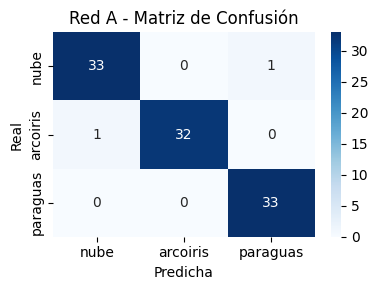

In [16]:
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, roc_auc_score, confusion_matrix, classification_report


def evaluar_modelo(modelo, imagenes, etiquetas, nombre_modelo):
    probabilidades = modelo.predict(imagenes)
    predicciones = probabilidades.argmax(axis=1)
    exactitud = accuracy_score(etiquetas, predicciones)
    precision, recall, f1, _ = precision_recall_fscore_support(etiquetas, predicciones, average='macro', zero_division=0)
    auc = roc_auc_score(etiquetas, probabilidades, multi_class='ovr')
    matriz = confusion_matrix(etiquetas, predicciones)
    reporte = classification_report(
        etiquetas,
        predicciones,
        target_names=[MAPA_ETIQUETAS[k] for k in sorted(MAPA_ETIQUETAS.keys())],
        zero_division=0
    )
    metricas = {
        'modelo': nombre_modelo,
        'exactitud': exactitud,
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'roc_auc': auc
    }
    return metricas, matriz, reporte


def graficar_confusion(matriz, titulo):
    plt.figure(figsize=(4,3))
    sns.heatmap(matriz, annot=True, fmt='d', cmap='Blues', xticklabels=MAPA_ETIQUETAS.values(), yticklabels=MAPA_ETIQUETAS.values())
    plt.title(titulo)
    plt.ylabel('Real')
    plt.xlabel('Predicha')
    plt.tight_layout()
    plt.show()


metricas_red_a, matriz_red_a, reporte_red_a = evaluar_modelo(modelo_red_a, imgs_prueba, etq_prueba, 'Red A (Transfer Learning)')
print(metricas_red_a)
print('\nReporte de clasificación Red A:\n', reporte_red_a)
graficar_confusion(matriz_red_a, 'Red A - Matriz de Confusión')

## 5. Entrenar Red B (Arquitectura Optimizada desde Cero)
Red B se entrena desde cero únicamente con los 500 bocetos. Mantenemos dropout para regularizar y usamos los mismos callbacks de reducción de LR/parada temprana para que el aprendizaje sea estable sin ignorar ninguna clase.

In [17]:
def entrenar_red_b(imgs_entrenamiento, etq_entrenamiento, imgs_validacion, etq_validacion, epocas=15):
    red_b = construir_cnn(num_clases=3, tasa_dropout=0.3)
    red_b.compile(optimizer=Adam(1e-4), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    historial = red_b.fit(
        imgs_entrenamiento,
        etq_entrenamiento,
        validation_data=(imgs_validacion, etq_validacion),
        batch_size=32,
        epochs=epocas,
        callbacks=[
            ReduceLROnPlateau(factor=0.5, patience=3, verbose=1),
            EarlyStopping(patience=5, restore_best_weights=True)
        ],
        verbose=1
    )
    return red_b, historial


modelo_red_b, historial_red_b = entrenar_red_b(
    imgs_entrenamiento,
    etq_entrenamiento,
    imgs_validacion,
    etq_validacion
)

Epoch 1/15
10/10 [==============================] - 1s 25ms/step - loss: 1.0623 - accuracy: 0.4133 - val_loss: 1.0258 - val_accuracy: 0.6400 - lr: 1.0000e-04
Epoch 2/15
10/10 [==============================] - 1s 25ms/step - loss: 1.0623 - accuracy: 0.4133 - val_loss: 1.0258 - val_accuracy: 0.6400 - lr: 1.0000e-04
Epoch 2/15
10/10 [==============================] - 0s 12ms/step - loss: 0.9978 - accuracy: 0.7167 - val_loss: 0.9578 - val_accuracy: 0.8500 - lr: 1.0000e-04
Epoch 3/15
10/10 [==============================] - 0s 12ms/step - loss: 0.9978 - accuracy: 0.7167 - val_loss: 0.9578 - val_accuracy: 0.8500 - lr: 1.0000e-04
Epoch 3/15
10/10 [==============================] - 0s 11ms/step - loss: 0.9234 - accuracy: 0.8267 - val_loss: 0.8759 - val_accuracy: 0.9100 - lr: 1.0000e-04
Epoch 4/15
10/10 [==============================] - 0s 11ms/step - loss: 0.9234 - accuracy: 0.8267 - val_loss: 0.8759 - val_accuracy: 0.9100 - lr: 1.0000e-04
Epoch 4/15
10/10 [==============================] - 

## 6. Evaluar Red B (Métricas + Matriz de Confusión)
Usamos las mismas métricas para poder comparar directamente y observar la mejora al especializar el entrenamiento en los bocetos reales.

4/4 [==============================] - 0s 3ms/step
{'modelo': 'Red B (Desde Cero)', 'exactitud': 0.97, 'precision': 0.9705357142857144, 'recall': 0.9699940582293524, 'f1': 0.9701226309921962, 'roc_auc': 0.9977563164569311}

Reporte de clasificación Red B:
               precision    recall  f1-score   support

        nube       0.94      0.97      0.96        34
    arcoiris       0.97      0.94      0.95        33
    paraguas       1.00      1.00      1.00        33

    accuracy                           0.97       100
   macro avg       0.97      0.97      0.97       100
weighted avg       0.97      0.97      0.97       100

{'modelo': 'Red B (Desde Cero)', 'exactitud': 0.97, 'precision': 0.9705357142857144, 'recall': 0.9699940582293524, 'f1': 0.9701226309921962, 'roc_auc': 0.9977563164569311}

Reporte de clasificación Red B:
               precision    recall  f1-score   support

        nube       0.94      0.97      0.96        34
    arcoiris       0.97      0.94      0.95    

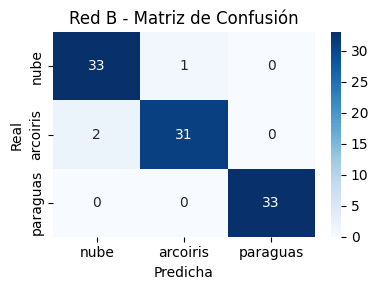

In [18]:
metricas_red_b, matriz_red_b, reporte_red_b = evaluar_modelo(modelo_red_b, imgs_prueba, etq_prueba, 'Red B (Desde Cero)')
print(metricas_red_b)
print('\nReporte de clasificación Red B:\n', reporte_red_b)
graficar_confusion(matriz_red_b, 'Red B - Matriz de Confusión')

## 7. Comparar el Desempeño de las Redes
Consolidamos las métricas en una tabla y graficamos las matrices de confusión lado a lado para visualizar claramente los aciertos/errores de cada enfoque.

,modelo,exactitud,precision,recall,f1,roc_auc
0,Red A (Transfer Learning),0.98,0.980392,0.980095,0.980093,0.995198
1,Red B (Desde Cero),0.97,0.970536,0.969994,0.970123,0.997756


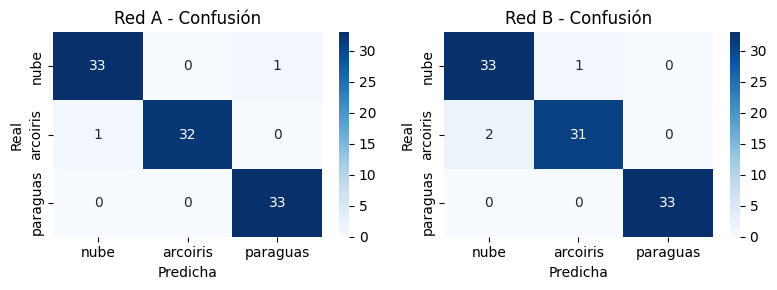

In [19]:
df_metricas = pd.DataFrame([metricas_red_a, metricas_red_b])
display(df_metricas)

fig, ejes = plt.subplots(1, 2, figsize=(8,3))
for eje, matriz, titulo in zip(
    ejes,
    [matriz_red_a, matriz_red_b],
    ['Red A', 'Red B']
):
    sns.heatmap(matriz, annot=True, fmt='d', cmap='Blues', xticklabels=MAPA_ETIQUETAS.values(), yticklabels=MAPA_ETIQUETAS.values(), ax=eje)
    eje.set_title(f'{titulo} - Confusión')
    eje.set_ylabel('Real')
    eje.set_xlabel('Predicha')
plt.tight_layout()
plt.show()

## Informe en documento separado
El informe escrito completo se entrega fuera de este cuaderno en el archivo `Informe_Trabajo_Final.docx`.